# 1. Setup

In [1]:
import pickle
from time import time

from lightgbm import LGBMRegressor, plot_tree
from matplotlib.patches import Patch
import plotly.express as px
from scipy.stats import entropy
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sklearn as skl

from utils import *

# 2. Load data and models

## 2.1. Data

In [2]:
trips = pd.read_parquet('../data/nhts/trips.parquet').disp()

739,164 rows x 32 cols; Memory: 47.2 MiB


Distance   Duration      Speed LogDistance TripWeight   HomeBased  \
   <float64>  <float64>  <float64>   <float64>  <float64>  <category>   
0   8.439379       15.0  33.757516    3.926362   0.006319         yes   

      Purpose        Mode     VehType     Weekend  ...      Region  \
   <category>  <category>  <category>  <category>  ...  <category>   
0      social       drive         car          no  ...       south   

      MSAKind      UrbanO      UrbanD PopDensityO PopDensityD HouseDensityO  \
   <category>  <category>  <category>  <category>  <category>    <category>   
0       small    suburban    suburban         mid         low           mid   

  HouseDensityD EmpDensityO EmpDensityD  
     <category>  <category>  <category>  
0           low         mid         low  

[2 rows x 32 columns]

In [3]:
feature_grps = pd.concat([
    Pdf(D(feature=trips.loc[:, start: end].columns)).assign(group=grp) 
    for grp, (start, end) in {
        'Trip': ('HomeBased', 'StartTime'),
        'SES': ('AgeGrp', 'HomeOwn'),
        'OD': ('Region', 'EmpDensityD')
    }.items()]).reset_index(drop=1).disp(3)

27 rows x 2 cols; Memory: 0.0 MiB


feature     group
    <object>  <object>
0  HomeBased      Trip
1    Purpose      Trip
2       Mode      Trip

In [4]:
ds_full = {trg: Dataset(trips, trg, rng, 0.3) for trg, rng in 
           D(LogDistance=(2, 5), Duration=(0, 90)).items()}

## 2.2. Model

In [5]:
models = load_pickle('../data/nhts/selected_models.pkl')
models['Duration']

LGBMRegressor(force_row_wise=True, learning_rate=0.05, n_jobs=-1, verbosity=0)

## 2.3. Interactive distributions

In [6]:
def plot_distr_vars(data=trips, width=1600, height=500):
    res = []
    for measure, vmin, vmax in [('Duration', 0, 90), ('LogDistance', 1, 6), ('Speed', 0, 80)]:
        for var in data.select_dtypes(CAT):
            for cat, df in data.groupby(var):
                y, x = np.histogram(df[measure].clip(vmin, vmax), 
                                    bins=100, weights=df.TripWeight)
                y = (y / y.sum()).cumsum()
                res.append(Pdf(D(value=x[1:], density=y))
                           .assign(var=var, cat=cat, measure=measure))
    res = pd.concat(res).reset_index(drop=1)
    fig = px.line(res, x='value', y='density', color='var', facet_col='measure',
                  width=width, height=height, hover_name='cat', hover_data=['cat'],
                  labels=D(density='Cumulative probability density', var='Factor'))
    fig.update_layout(hoverlabel=D(bgcolor='white', font_size=16),
                      font=D(family='Arial', size=18))
    fig.for_each_xaxis(lambda x: x.update(matches=None))
    fig.show()

plot_distr_vars()

## 2.4. Feature level KL divergences

In [7]:
def plot_cat_entropy(trips=trips, size=(10, 3), dpi=150, gap=0.2):
    hist = lambda df: np.histogram(df.val, bins=100, density=True, weights=df.TripWeight)[0]
    ent = [] # table containing entropy values
    for var, vmin, vmax in [('LogDistance', 2, 5), ('Duration', 0, 90)]:
        trips = trips.assign(val=trips[var].clip(vmin, vmax))
        all_hist = hist(trips)
        for col in trips.select_dtypes(CAT).columns:
            for j, (cat, df) in enumerate(trips.groupby(col)):
                ent.append(D(var=var, col=col, cat_id=j, cat=cat, n=len(df),
                             entropy=entropy(hist(df), all_hist)))
    ent = Pdf(ent)
    cols = ent.groupby(['var', 'col']).entropy.agg(['min', 'max']).reset_index()
    cols['range'] = cols['max'] - cols['min']
    col_ids = (cols.query('var=="LogDistance"').set_index('col')['range']
               .sort_values(ascending=0).reset_index().rename_axis('col_id'))
    cols = cols.merge(col_ids['col'].reset_index(), on='col')
    cols['x'] = cols.col_id + gap * 2 * ((cols['var'] == 'Duration') - 0.5)
    ent = ent.merge(cols[['var', 'col', 'col_id', 'x']], on=('var', 'col'))
    ax = pplot(size=size, dpi=dpi, ylab='KL divergence', ylog=0)
    for var, color in [('LogDistance', 'c'), ('Duration', 'y')]:
        df = ent.query(f'var=="{var}"')
        ax.scatter(df.x, df.entropy, s=15, color='#bbb')
        for _, r in df.iterrows():
            ax.text(r.x, r.entropy, str(r.cat_id + 1), fontsize=7,
                    color='k', ha='center', va='center')
        for _, r in cols.query(f'var=="{var}"').iterrows():
            ax.add_artist(mpl.lines.Line2D(
                [r.x, r.x], [r['min'], r['max']], lw=8, 
                alpha=0.4, color=color, solid_capstyle='round'))
    ax.set_xticks(ent.col_id.unique(), ent.col.unique(), fontsize=10, rotation=90)
    ax.tick_params(which='minor', bottom=False)
    ax.legend(handles=[mpl.patches.Patch(fc=c, label=x, ec='none') for x, c in [
        ('Log(Distance (km))', 'c'), ('Duration (min)', 'y')]])

# plot_cat_entropy(dpi=150) # t=0:05

# 3. SHAP analysis

## 3.1. Row-wise SHAP values

### 3.1.1. For factor levels

In [8]:
def get_shap(models, datasets, seed=1234, overwrite=False):
    outpath = Path('../data/nhts/shap_levels.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    for target in tqdm(['LogDistance', 'Duration']):
        ds, model = datasets[target], models[target]
        explainer = shap.TreeExplainer(model, seed=seed)
        shaps = explainer(ds.X).values
        df = Pdf(shaps, columns=ds.X.columns).astype(np.float32)
        df = df.rename_axis('row_id').reset_index().astype(D(row_id=np.int32))
        df.insert(0, 'target', target)
        res.append(df)
    res = pd.concat(res).reset_index(drop=1).astype(D(target=CAT))
    res.to_parquet(mkfile(outpath))
    return res

shap_level = get_shap(models, ds_full, overwrite=0).disp() # t=1:18

1,478,328 rows x 83 cols; Memory: 463.8 MiB


target   row_id HomeBased__no HomeBased__yes Purpose__work  \
    <category>  <int32>     <float32>      <float32>     <float32>   
0  LogDistance        0      0.008874       0.001487     -0.012188   

  Purpose__shopping Purpose__social Purpose__medical Purpose__recreation  \
          <float32>       <float32>        <float32>           <float32>   
0          0.005016       -0.002207        -0.001731           -0.000769   

  Mode__drive  ... HouseDensityO__high HouseDensityD__low HouseDensityD__mid  \
    <float32>  ...           <float32>          <float32>          <float32>   
0     0.00016  ...           -0.000014           0.027346            0.00005   

  HouseDensityD__high EmpDensityO__low EmpDensityO__mid EmpDensityO__high  \
            <float32>        <float32>        <float32>         <float32>   
0           -0.000291         0.000344         0.000058         -0.000101   

  EmpDensityD__low EmpDensityD__mid EmpDensityD__high  
         <float32>        <float32>         <float32>  
0        -0.000139         0.000037         -0.000044  

[2 rows x 83 columns]

### 3.1.2. For features

In [9]:
# t=0:07
# shap_feature = shap_level[['target', 'row_id']]
# for feat in feature_grps.feature:
#     col = np.abs(shap_level.filter(like=feat + '__')).sum(1).rename(feat)
#     shap_feature = pd.concat([shap_feature, col], axis=1)
# shap_feature.to_parquet('../data/nhts/shap_features.parquet')
shap_feature = pd.read_parquet('../data/nhts/shap_features.parquet').disp()

1,477,666 rows x 30 cols; Memory: 164.9 MiB


target   row_id  HomeBased    Purpose       Mode    VehType  \
    <category>  <int32>  <float32>  <float32>  <float32>  <float32>   
0  LogDistance        0   0.010469   0.024432   0.031936    0.00132   

     Weekend  Occupancy   GasPrice  StartTime  ...     Region    MSAKind  \
   <float32>  <float32>  <float32>  <float32>  ...  <float32>  <float32>   
0   0.000754   0.011589   0.000061   0.005737  ...   0.008235   0.018539   

      UrbanO     UrbanD PopDensityO PopDensityD HouseDensityO HouseDensityD  \
   <float32>  <float32>   <float32>   <float32>     <float32>     <float32>   
0   0.009317   0.007385    0.001875    0.005211      0.006674      0.027309   

  EmpDensityO EmpDensityD  
    <float32>   <float32>  
0    0.000349     0.00016  

[2 rows x 30 columns]

In [10]:
shap_feature_contrib = (
    (shap_feature.drop(columns='row_id')
    .groupby('target').apply(sum) / (len(shap_feature) / 2))
    .reset_index().melt('target', var_name='feature', value_name='abs_shap')
).disp()

56 rows x 3 cols; Memory: 0.0 MiB


target    feature   abs_shap
   <category>   <object>  <float32>
0    Duration  HomeBased   0.002417

## 3.2. Intra- and inter-feature importance

In [11]:
def fig_feature_selection(trips, shaps, grps=feature_grps, win=5,
                          size=(10, 6), dpi=150):
    pts = [] # table for distributional summary value for each factor level
    features = trips.select_dtypes(CAT).columns
    mean_auc = {}
    for target, vmin, vmax in [('Duration', 0, 90), ('LogDistance', 2, 5)]:
        def auc(df): # area under curve of CDF
            y, x = np.histogram(df[target].clip(vmin, vmax + win), 
                                bins=100, weights=df.TripWeight, density=1)
            y = Series(y[::-1]).rolling(win).median()[::-1].fillna(0)
            F = (y / y.sum()).cumsum() # CDF
            return (F * x[:-1]).sum() / x[:-1].sum() # area under curve of CDF
        mean_auc[target] = auc(trips)
        for feat in features: # for each feature
            for j, (cat, df) in enumerate(trips.groupby(feat)): # for each level
                if feat == 'VehType' and cat == 'other': continue
                pts.append(D(target=target, feature=feat, cat_id=j, cat=cat, value=auc(df)))
    pts = Pdf(pts)
    res = (pts.groupby(['target', 'feature'])['value'].agg(['min', 'max'])
           .rename(columns='auc_{}'.format).reset_index()
           .merge(shaps, on=('target', 'feature')))
    res = res.merge(grps, on='feature')
    res.feature = pd.Categorical(res.feature, categories=features)
    res['color'] = res.group.map(D(Trip='deepskyblue', SES='coral', OD='gold'))
    res['pos'] = len(features) - res.feature.cat.codes - 1
    _, axes = plt.subplots(1, 4, figsize=size, dpi=dpi, sharey=True)
    for i, (target, vmax) in enumerate([('LogDistance', 0.3), ('Duration', 0.2)]):
        ## AUC
        ax = pplot(axes[i], xlab='AUC$_{%s}$' % target, xlog=0)
        df = pts.merge(res, on=('target', 'feature')).query(f'target=="{target}"')
        ax.scatter(df.value, df.pos, s=15, color='#ccc')
        ax.axvline(mean_auc[target], ls='-', color='k', lw=1, alpha=0.8)
        for _, r in df.iterrows():
            ax.text(r.value, r.pos, str(r.cat_id + 1), fontsize=7,
                    color='k', ha='center', va='center')
        df = res[res['target'] == target].sort_values('feature')
        for _, r in df.iterrows():
            ax.add_artist(mpl.lines.Line2D(
                [r.auc_min, r.auc_max], [r.pos] * 2, lw=8.5,
                alpha=1, color=r.color, solid_capstyle='round'))
        ## SHAP values
        ax = pplot(axes[i + 2], xlab='Mean(|SHAP$_{%s}$|)' % target)
        ax.barh(df.pos, df.abs_shap, tick_label=df.feature, 
                color=df.color, alpha=0.8, height=0.7)
    for i, ax in enumerate(axes):
        ax.set_ylim(-0.5, len(features) - 0.5)
        ax.tick_params(which='minor', left=False)
    plt.subplots_adjust(wspace=0.05)

# fig_feature_selection(trips, shap_feature_contrib, dpi=300) # t=0:05

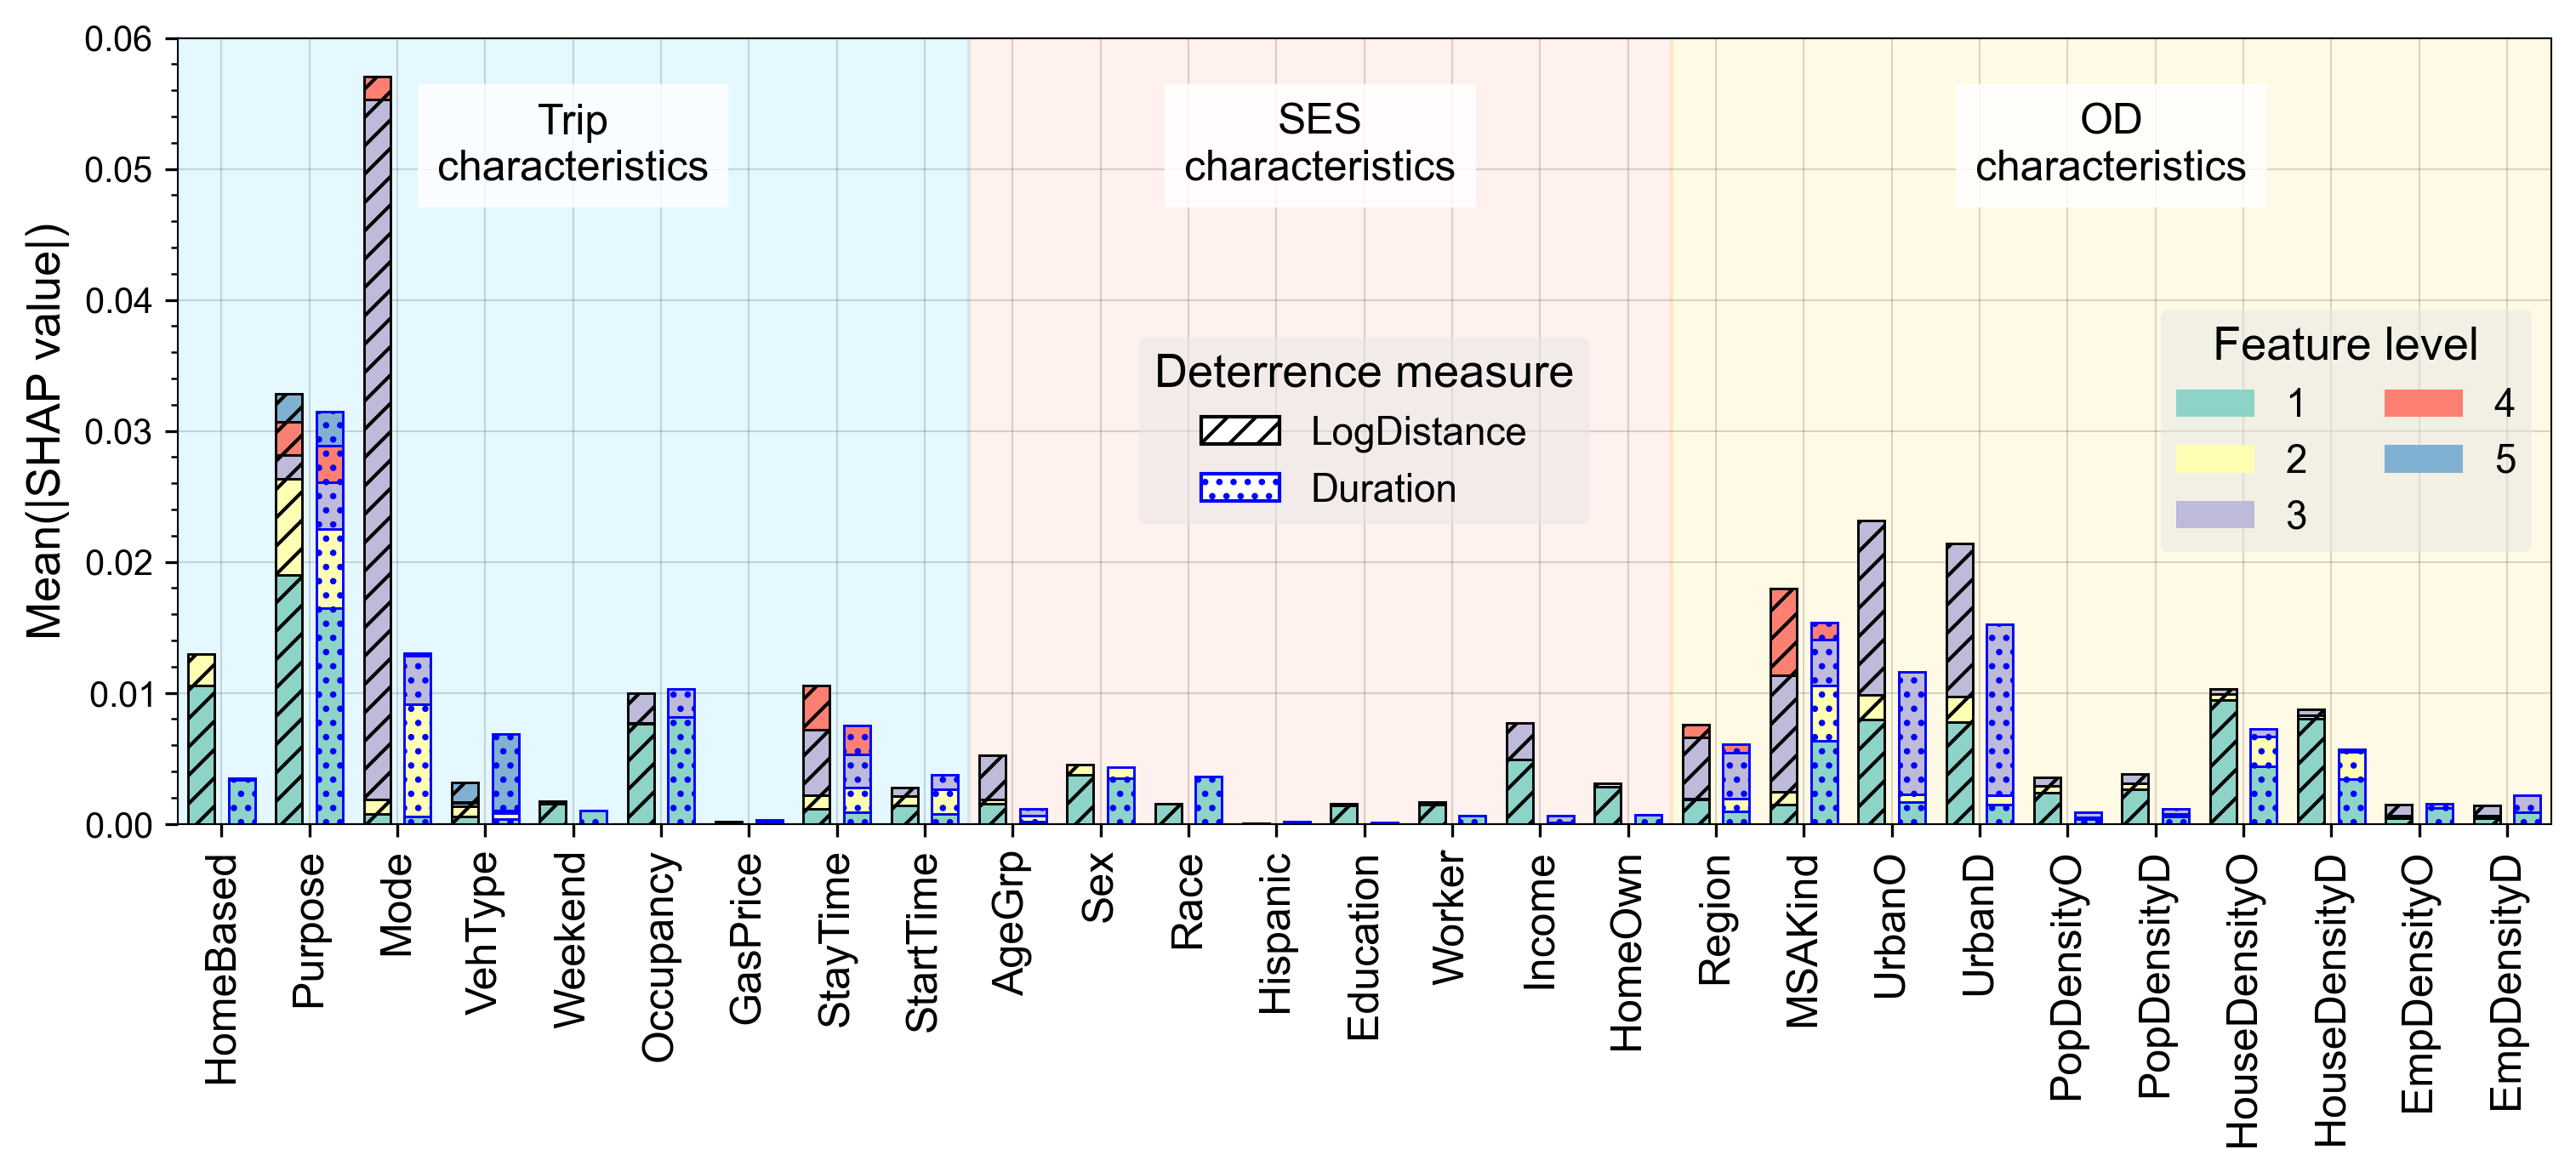

In [12]:
def fig_feature_selection2(shaps, feats=feature_grps, dx=0.08, width=0.3,
                           size=(12, 4), dpi=150, cmap='Set3'):
    sh = np.abs(shaps.drop(columns='row_id').set_index('target'))
    sh = sh.groupby('target').mean(0).reset_index().melt('target')
    sh['feature'] = sh.variable.str.split('__').str[0]
    sh['level'] = sh.variable.str.split('__').str[1]
    targets = [('LogDistance', 'k', '///'), ('Duration', 'b', '...')]
    grps = feats.groupby('group', sort=0).size().rename('width').reset_index()
    grps['start'] = grps.width.cumsum().shift().fillna(0)
    ax = pplot(size=size, dpi=dpi, ylab='Mean(|SHAP value|)', xminor=0)
    for i, (trg, color, hatch) in enumerate(targets):
        for j, feat in enumerate(feats.feature):
            df = sh.query(f'target=="{trg}" & feature=="{feat}"').copy()
            df['bottom'] = df.value.cumsum().shift().fillna(0)
            df['color'] = sns.color_palette(cmap, len(df))
            df.color = df.color.apply(mpl.colors.to_hex)
            for _, r in df.iterrows():
                x = j + (2 * i - 1) * (dx + width / 2) - width / 2
                ax.add_artist(mpl.patches.Rectangle(
                    (x, r.bottom), width, r.value,
                    color=r.color, ec=color, lw=0.7, hatch=hatch))
            # ax.bar(j + dx * (i - 0.5), df.value, width, 0,
            #        color=df.color, ec=color, lw=0.7, hatch=hatch)
    ax.set_xticks(range(len(feats)), feats.feature, rotation=90, fontsize=12)
    ax.set_xlim(-0.5, len(feats) - 0.5)
    ax.set_ylim(0, 0.06)
    for (_, r), color in zip(grps.iterrows(), ['deepskyblue', 'coral', 'gold']):
        ax.axvspan(r.start - 0.5, r.start + r.width - 0.5, color=color, alpha=0.1, zorder=-1)
        ax.text(r.start - 0.5 + r.width / 2, 0.055, f'{r.group}\ncharacteristics',
                color='k', ha='center', va='top', fontsize=12,
                bbox=D(pad=5, color='w', alpha=0.8))
    leg1 = plt.legend(loc='center', title='Deterrence measure', handles=[
        mpl.patches.Patch(fc='w', ec=c, hatch=h, label=l) for l, c, h in targets])
    plt.gca().add_artist(leg1)
    max_levels = sh.groupby(['target', 'feature']).size().max()
    colors = sns.color_palette(cmap, max_levels)
    labels = [str(i + 1) for i in range(len(colors))]
    plt.legend(loc='center right', ncol=2, title='Feature level', handles=[
        mpl.patches.Patch(fc=c, ec='none', label=l) for c, l in zip(colors, labels)])

x = fig_feature_selection2(shap_level, dpi=300); x # t=0:04

## 3.3. Important distributions

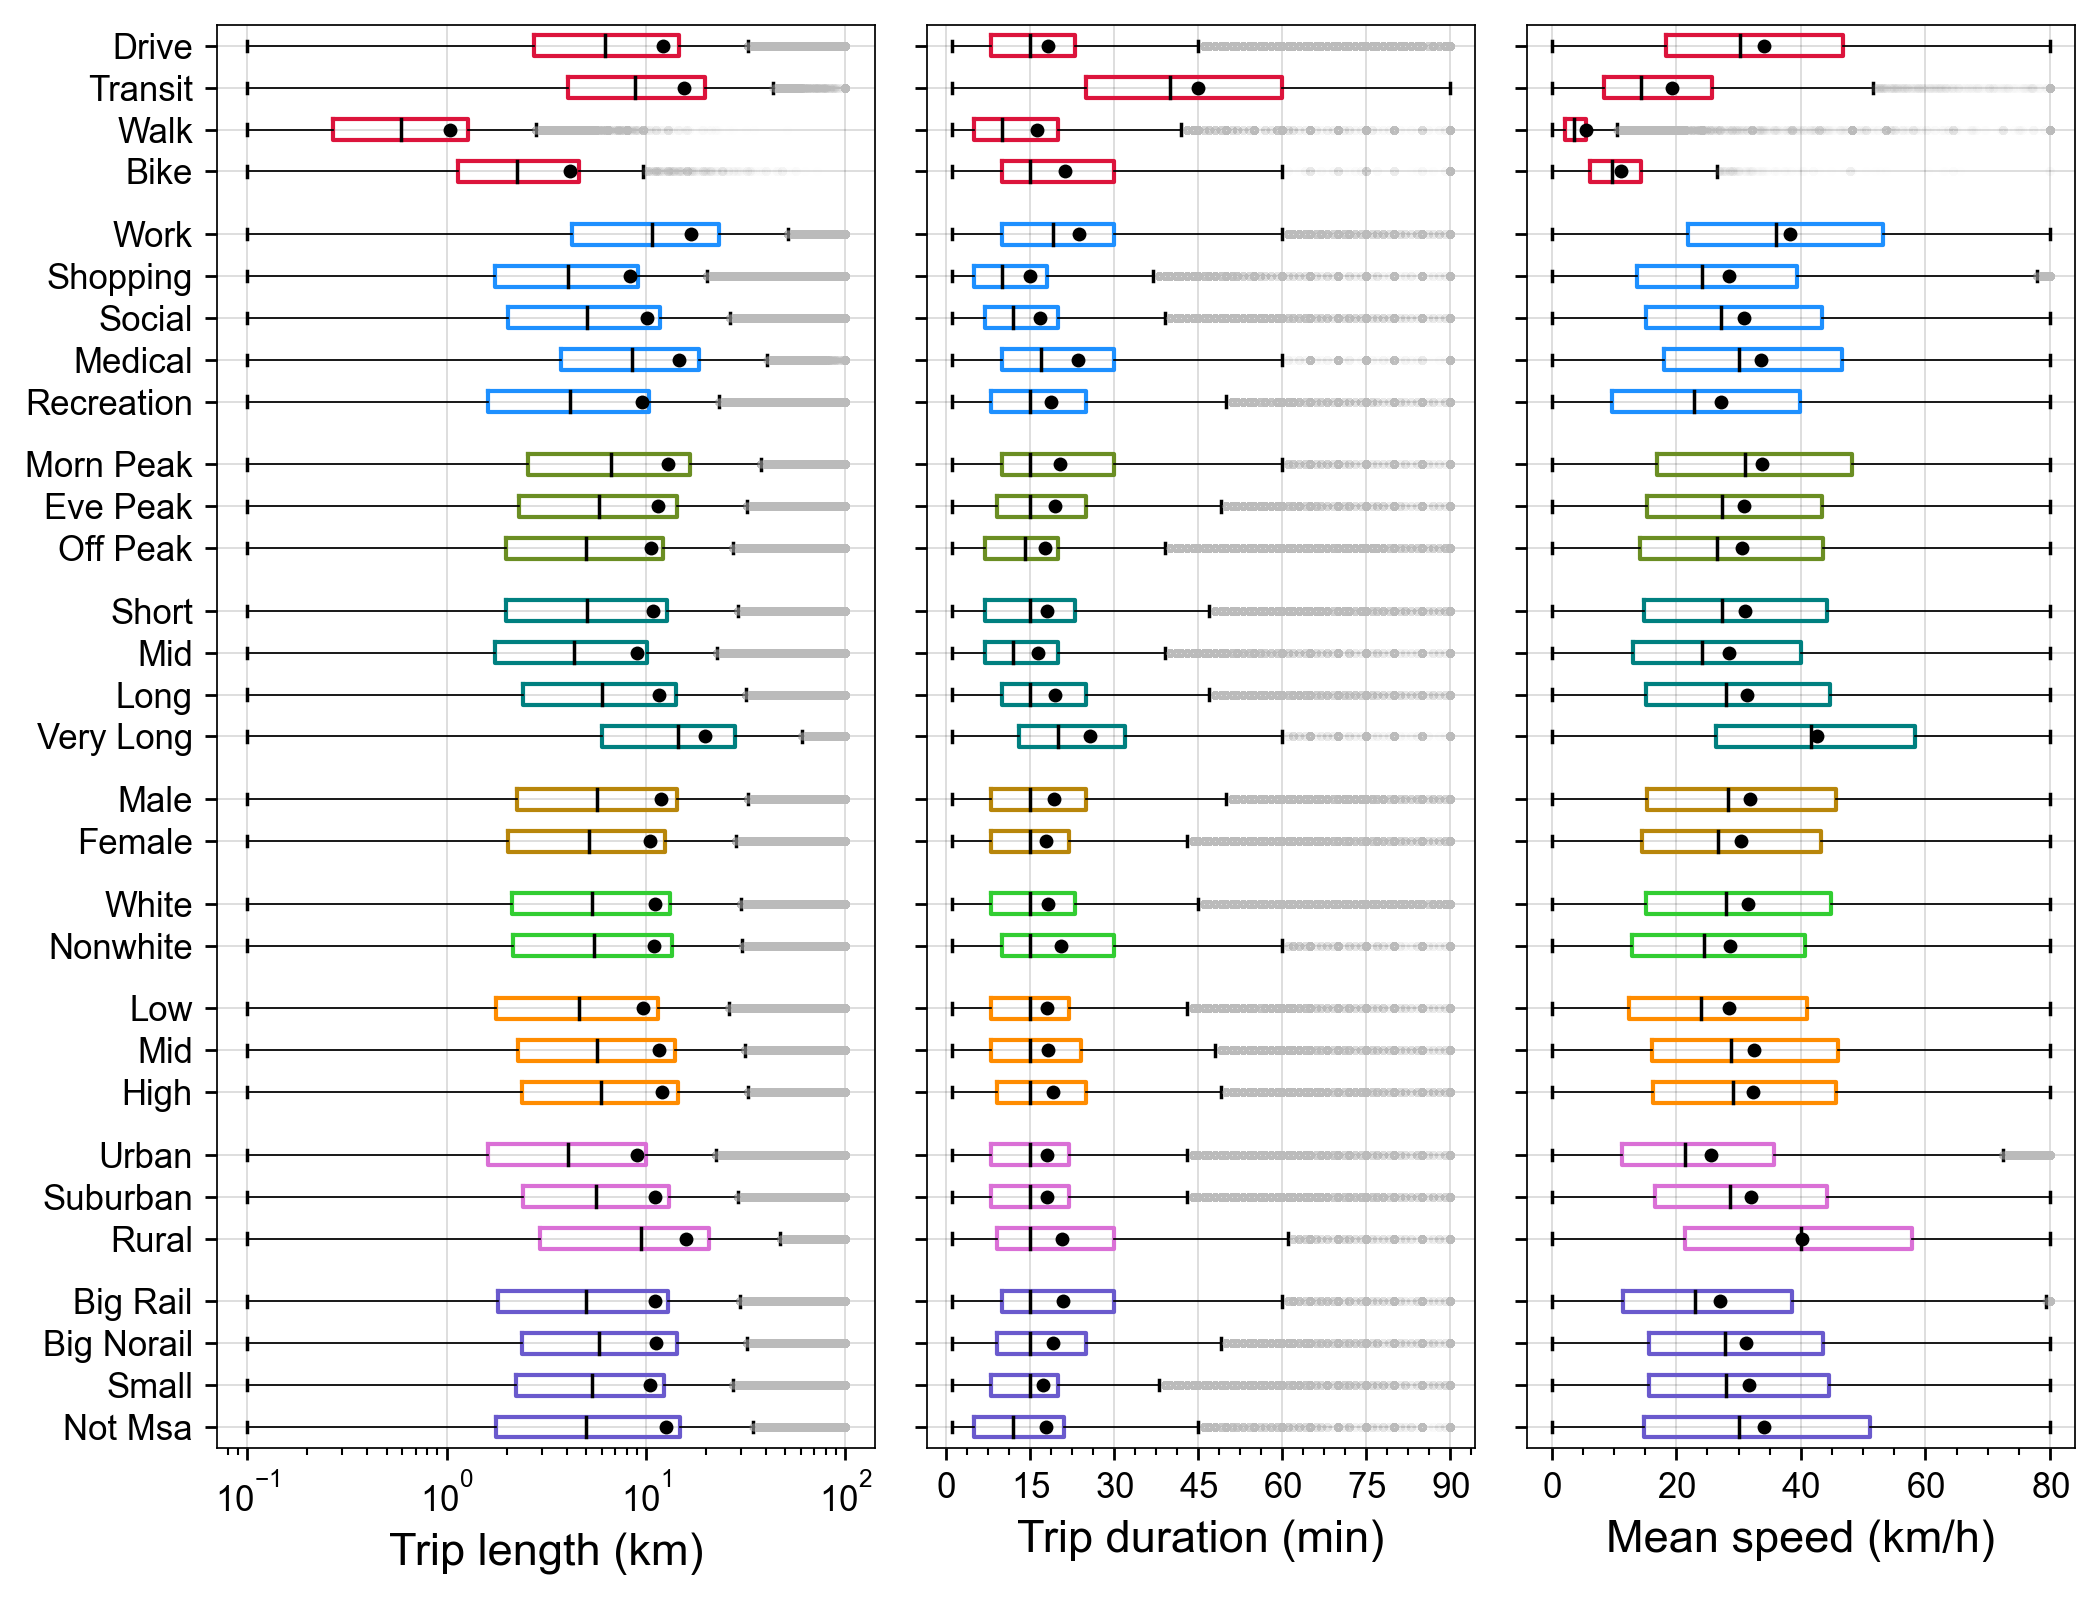

In [13]:
def plot_distr_box(trips=trips, size=(8.5, 6.5), dpi=150):
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    cols = D(Mode='crimson', Purpose='dodgerblue',
             StartTime='olivedrab', StayTime='teal',
             Sex='darkgoldenrod', Race='limegreen', Income='darkorange',
             UrbanO='orchid', MSAKind='slateblue')
    ticker = mpl.ticker.EngFormatter(places=1)
    for j, (var, label, rng) in enumerate([
            ('Distance', 'Trip length (km)', (0.1, 100)),
            ('Duration', 'Trip duration (min)', (0, 90)),
            ('Speed', 'Mean speed (km/h)', (0, 80))]):
        df = Pdf(sum([[D(col=col, cat=x[0].title().replace('_', ' '),
                         vals=x[1].values, pos=i / 2, n=ticker(len(x[1]))) 
                       for x in trips.groupby(col)[var]]
                      for i, col in enumerate(cols.keys())], []))
        df.vals = [x.clip(*rng) for x in df.vals]
        df['color'] = df.col.map(cols)
        ax = pplot(axes[j], xlog=var == 'Distance', xlab=label)
        x = ax.boxplot(
            df.vals, positions=df.pos + df.index, labels=df.cat,
            vert=False, whiskerprops=D(lw=0.5), boxprops=D(lw=1.2),
            flierprops=D(markersize=1.5, markeredgecolor='#bbb', alpha=0.01),
            showmeans=True, meanline=False, medianprops=D(color='k'),
            meanprops=D(markersize=4, markeredgecolor='none',
                        marker='o', markerfacecolor='k'))
        for box, color in zip(x['boxes'], df.color):
            box.set_color(color)
        ax.tick_params(which='minor', left=False)
        ax.invert_yaxis()
        if var == 'Duration': ax.set_xticks(np.arange(0, 91, 15))
        if j != 0: ax.set_yticklabels([])
    plt.tight_layout()

plot_distr_box(dpi=250)

# 4. OD: Density & urbanity

In [14]:
od_cols = pd.get_dummies(trips[feature_grps.query('group=="OD"').feature], prefix_sep='__').columns

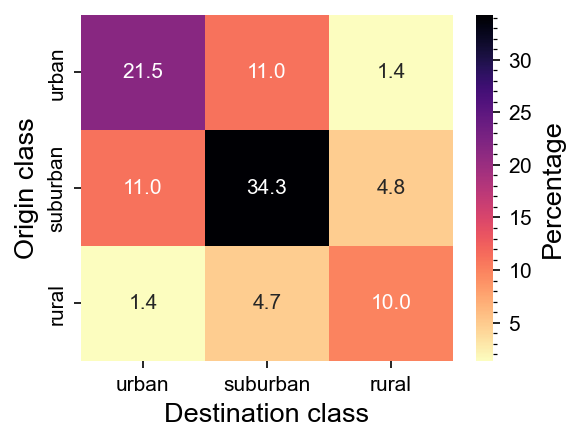

In [15]:
ax = pplot(size=(4, 3), dpi=150)
sns.heatmap(trips[['UrbanO', 'UrbanD']].value_counts()
            .pipe(lambda x: x / x.sum() * 100).reset_index()
            .pivot_table('count', 'UrbanO', 'UrbanD'),
            ax=ax, cmap='magma_r', annot=True, fmt='.1f',
            cbar_kws=D(label='Percentage'))
ax.minorticks_off(); ax.grid(False)
ax = pplot(ax, xlab='Destination class', ylab='Origin class')

In [16]:
# trips[feature_grps.query('group=="OD"')['feature']].value_counts()

# 5. SES

In [17]:
ses_feats = feature_grps.query('group=="SES"').feature
# ses_cols = ('AgeGrp', 'Race', 'Sex', 'HomeOwn', 'Income')

## 5.1. Select SES factors

### 5.1.1. For duration
- Race
- Sex

In [18]:
def fig_pca_ses_duration(feats=ses_feats, trips=trips, shaps=shap_level,
                         size=(12, 4), dpi=150):
    shaps = shaps.query('target=="Duration"')
    X = pd.concat([shaps.filter(like=f + '__') for f in feats], axis=1)
    pca = PCA(X.shape[1]).fit(X)
    X2 = Pdf(pca.transform(X)[:, :2])
    _, axes = plt.subplots(1, 3, figsize=size, dpi=dpi,
                           gridspec_kw=D(width_ratios=[1.2, 1, 1]))
    colors = sns.color_palette('pastel', pca.n_components_)
    vals = pca.explained_variance_ratio_
    vals = list(vals[:2]) + [vals[2:].sum()]
    labels = [f'{x}\n({y * 100:.1f}%)' for x, y in zip(
        ['PC1', 'PC2', 'Others'], vals)]
    axes[0].pie(vals, labels=labels, colors=colors,
                labeldistance=0.5, startangle=90)
    for i, (feat, level, other) in enumerate([
            ('Race', 'white', 'non-white'), ('Sex', 'male', 'female')]):
        ax = pplot(axes[i + 1], xlab='PC1', ylab='PC2')
        colors = {True: 'tomato', False: 'royalblue'}
        labels = {True: level.title(), False: other.title()}
        df = pd.concat([X2, (trips[feat] == level).rename('yes')], axis=1)
        ax.scatter(df[0], df[1], c=df['yes'].map(colors), s=2, alpha=0.5)
        ax.legend(loc='upper right', handles=[
            mpl.lines.Line2D([0], [0], marker='o', markerfacecolor=c,
                             markeredgecolor='none', lw=0, label=l)
            for l, c in zip(labels.values(), colors.values())])
        for f in [ax.axvline, ax.axhline]:
            f(0, color='k', ls='--', lw=1)
        if i > 0: ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0.2)

# fig_pca_ses_duration(dpi=250) # t=0:35

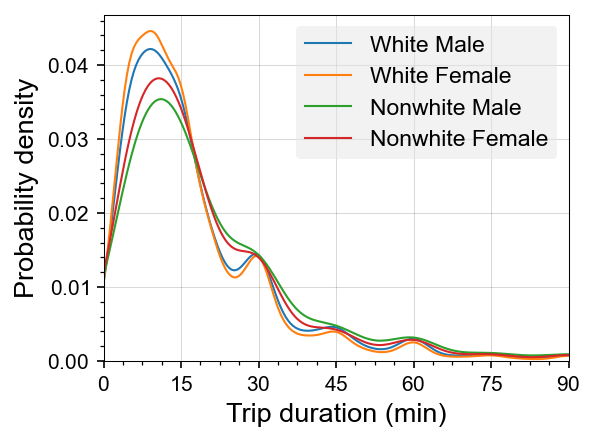

In [19]:
def plot(trips=trips, target='Duration', xcols=['Race', 'Sex'],
         rng=(0, 90), size=(4, 3), dpi=150):
    ax = pplot(size=size, dpi=dpi, xlim=rng)
    for cols, df in trips.groupby(xcols):
        sns.kdeplot(df, x=target, bw_adjust=2, ax=ax, clip=rng,
                    lw=1, label=' '.join(cols).title())
    ax.set_xlabel('Trip duration (min)')
    ax.set_ylabel('Probability density')
    ax.set_xticks(np.arange(0, 91, 15))
    ax.legend()

x = plot(); x

### 5.1.2. For log(distance)

In [71]:
def get_pca(target, feats=ses_feats, shaps=shap_level):
    # cols = Series(shaps.filter(like='__').columns, name='col')
    # features = cols.str.split('__').str[0].drop_duplicates()
    shaps = shaps.query(f'target=="{target}"').set_index('row_id')
    X = Pdf()
    for feat in feats:
        x = np.abs(shaps.filter(like=feat + '__')).sum(1)
        X = pd.concat([X, x.rename(feat)], axis=1)
    pca = PCA(len(feats)).fit(X)
    return pca

x = get_pca('Duration'); x

PCA(n_components=8)

In [32]:
def get_distr_auc(target, feats=ses_feats, trips=trips, models=models):
    X, y = pd.get_dummies(trips[list(feats)], prefix_sep='__'), trips[target]
    # X, y = trips[list(feats)], trips[target]
    # cats = X.apply(lambda x: list(x.cat.categories))
    # return cats
    # return list(it.product(*[[f'{k}__{z}' for z in v] for k, v in cats.items()]))
    # n_combs = np.prod(cats.apply(len))
    # for col in X.columns:
    #     return X[col].cat.categories
    # LGBMRegressor(n_jobs=-1, )
    model = models[target].fit(X, y)
    r2 = r2_score(y, model.predict(X))
    print(f'R2 value: {r2:.3f}')
    return model

x = get_distr_auc('Duration'); x

R2 value: 0.007


LGBMRegressor(force_row_wise=True, learning_rate=0.05, n_jobs=-1, verbosity=0)

In [19]:
# ax = pplot(size=(16, 8), dpi=150)
# plot_tree(x, ax=ax);